In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from sklearn.utils import shuffle

<p> helper functions and classes </p>

In [39]:
def see_data_stored(data_from_customDataFunction):
  x = print('\nFirst iteration of data set: ', next(iter(data_from_customDataFunction)), '\n') # Display text and label.
  y =print('Length of data set: ', len(data_from_customDataFunction), '\n')                  # Print how many items are in the data set
  z = print('Entire data set: ', list(DataLoader(data_from_customDataFunction)), '\n')        # Print entire data set
  return x,y,z

In [40]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

### Prepare data

In [15]:
# Read in dataset 
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
#Combine treatment and control as pandas dataframe
nswre74_pd_df = pd.concat([nswre74_control,nswre74_treated])
#Drop the outcome variable -> as to not bias results
nswre74_pd_df.drop('re78', axis=1, inplace=True)
#Shuffle data
nswre74_pd_df = shuffle(nswre74_pd_df).reset_index(drop=True)
nswre74_pd_df

,treat,age,education,black,hispanic,married,nodegree,re74,re75
0,0,39,12,1,0,1,0,19785.32,6608.137
1,0,18,9,1,0,0,1,0.00,0.000
2,0,19,10,1,0,1,1,0.00,0.000
3,1,29,12,1,0,0,0,10881.94,1817.284
4,1,42,12,1,0,0,0,0.00,0.000
...,...,...,...,...,...,...,...,...,...
440,0,34,10,1,0,1,1,0.00,0.000
441,0,33,11,1,0,0,1,0.00,0.000
442,0,31,12,1,0,0,0,0.00,0.000
443,0,25,12,1,0,0,0,0.00,0.000


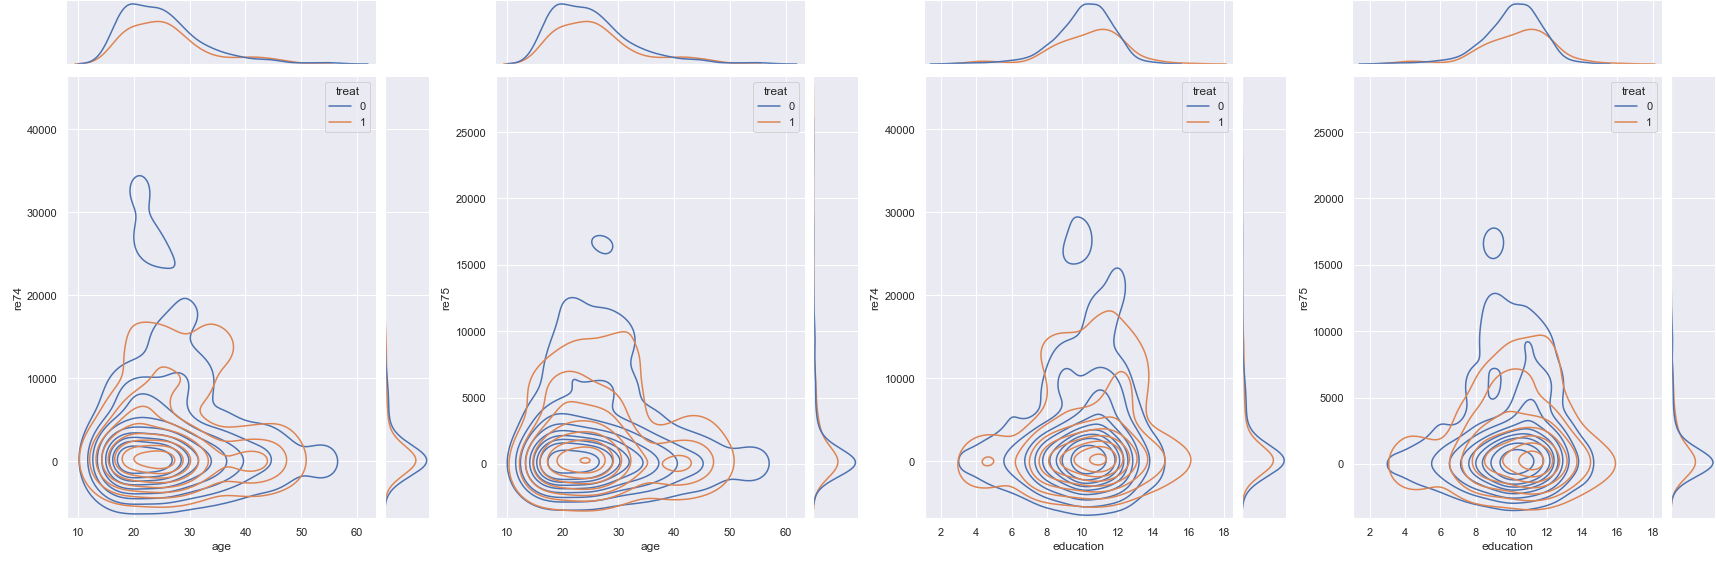

In [65]:
# Extected desicion boundary 
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nswre74_pd_df,x="age",y="re74", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nswre74_pd_df,x="age",y="re75", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nswre74_pd_df,x="education",y="re74", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nswre74_pd_df,x="education",y="re75", hue= hue, kind=plot_kind)

fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])
mg3 = SeabornFig2Grid(g3, fig, gs[3])

gs.tight_layout(fig)


#### Data pre-processing

In [1843]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

for col in nswre74_pd_df[['age','education','re74','re75']]:
    nswre74_pd_df[col] =  sc.fit_transform(np.array(nswre74_pd_df[col]).reshape(-1,1))

nsw_hold_out = nswre74_pd_df[400:445]
nswre74_pd_df = nswre74_pd_df[0:399]
nswre74_array = np.array(nswre74_pd_df)

features = nswre74_array[:,1:]     
target = nswre74_array[::,0]  

features = torch.tensor(features)
target = torch.tensor(target).unsqueeze(1)


#### Custom class for datasets

In [1844]:
class CustomDataset:
  def __init__(self,features,targets):    # initilise class 
    self.features = features              # import features
    self.targets = targets                # import targets 
  
  def __len__(self):
    #return self.features.shape[0]
    return len(self.features)

  def __getitem__(self,idx):
    current_sample = self.features[idx]
    current_target = self.targets[idx]
    sample = { "features": current_sample,"target": current_target} #Dictionairy storing data
    return  sample

 #"features": torch.tensor(current_sample,dtype=torch.float),
 #"target": torch.tensor(current_target,dtype=torch.float),
 

batch_size = 32

train_data, test_data, train_targets , test_targets = train_test_split(features,target,stratify=target)

# Convert datasets to tensors 
train_data= torch.tensor(train_data)
test_data= torch.tensor(test_data)

train_targets = torch.tensor(train_targets)
test_targets = torch.tensor(test_targets)

#Convert to float
train_data= train_data.type(torch.float)
test_data= test_data.type(torch.float)
train_targets= train_targets.type(torch.float)
test_targets= test_targets.type(torch.float)

# Place into custom dataset functions 
nsw_74_train = CustomDataset(features = train_data,targets = train_targets)
nsw_74_test = CustomDataset(features = test_data,targets = test_targets)

# Load in data loader
train_loader = DataLoader(dataset=nsw_74_train, batch_size=batch_size)
test_loader = DataLoader(dataset=nsw_74_test, batch_size=batch_size)



####  Construct NN

<p> set hyper parameters </p>

In [1845]:
# Number of input units, must match number of input features
number_of_inputs = features.shape[1]
# Number of hidden units    
n_hidden = 5
 # Number of output units                      
num_classes = 2

In [1846]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)
    

In [1847]:
# Define neural netowrk class 
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__() 
        self.input_layer =  nn.Linear(number_of_inputs,n_hidden)                        
        self.hidden_layer1 = nn.Linear(n_hidden,4)                          
        self.hidden_layer2 =  nn.Linear(4, 3) 
        self.hidden_layer3 =  nn.Linear(3, num_classes) 
       
        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        
    # Forward propogation method
    def forward(self, x):
        # input 
        x = self.input_layer(x)
        x = self.relu_activation(x)
        # first hidden layer
        x = self.hidden_layer1(x)
        x = self.relu_activation(x)
        # second hidden layer and output
        x = self.hidden_layer2(x)
        x = self.relu_activation(x)
        # third hidden layer and output
        x = self.hidden_layer3(x)
        x = self.output_activation(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using {device} device")

model = NeuralNetwork().to(device)                     #Initialise model
#model.apply(initialize_weights)


def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader
    correct = 0
    total = 0
    
    for (idx,batch) in enumerate(data):
        X = batch['features']
        Y = batch['target']
        X = X.float()
        #Y = Y.float()
        #print(X.size,X)
        output = model(X) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(Y.view_as(pred)).sum().item()
        total += X.shape[0]
    return correct / total

#### Training and evaluation loop

#Training loop

criterion = nn.BCELoss() # Binary cross entropy loss
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Stochastic gradient descent optimizer  

number_of_epochs = 3
n_total_steps = len(train_loader)

iters, losses, train_acc, val_acc = [], [], [], []

iteration = 0 #iteration number
for epoch in range(number_of_epochs):
    running_loss = 0
    for (idx,batch) in enumerate(train_loader): 
        
        print('training '+ str(idx))

        X = batch['features']
        Y = batch['target']
        X = X.float()
        Y = Y.float()

        model_output = model(X)             # Forward pass                        
        model_output = model_output[:,0]

        loss = criterion(model_output, Y)   #Calculate total loss
        loss.backward()                     # Backwards pass
        optimizer.step()                    # Update each parameter
        optimizer.zero_grad()               # Reset (clean up )
         
        # Gather data and report
        running_loss += loss.item()
        print (f'Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item():.4f}')
        running_loss = 0.0

        iters.append(iteration)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
        iteration += 1

# plotting
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))
            
print('Finished training')

### K-fold cross validation

<p> Initial settings <p>

In [1848]:
num_epochs=60
batch_size= 54
learning_rate = 1e-5
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [1849]:
# Set up data 
#features= torch.tensor(features)
#target= torch.tensor(target)
#features.type(torch.float32)
#target.type(torch.float32)

#target.clone().detach()
#features.clone().detach()

#Define data set object 
dataset = CustomDataset(features = features,targets = target)
see_data_stored(dataset)



First iteration of data set:  {'features': tensor([-0.6163,  1.5667,  1.0000,  0.0000,  0.0000,  0.0000, -0.3924, -0.4375],
       dtype=torch.float64), 'target': tensor([1.], dtype=torch.float64)} 

Length of data set:  399 

Entire data set:  [{'features': tensor([[-0.6163,  1.5667,  1.0000,  0.0000,  0.0000,  0.0000, -0.3924, -0.4375]],
       dtype=torch.float64), 'target': tensor([[1.]], dtype=torch.float64)}, {'features': tensor([[ 0.5117, -0.1092,  1.0000,  0.0000,  0.0000,  1.0000, -0.3924,  0.9601]],
       dtype=torch.float64), 'target': tensor([[1.]], dtype=torch.float64)}, {'features': tensor([[-0.0523,  0.4494,  0.0000,  1.0000,  1.0000,  1.0000, -0.3924, -0.4375]],
       dtype=torch.float64), 'target': tensor([[0.]], dtype=torch.float64)}, {'features': tensor([[-0.1933, -1.7851,  1.0000,  0.0000,  0.0000,  1.0000, -0.3924, -0.4375]],
       dtype=torch.float64), 'target': tensor([[0.]], dtype=torch.float64)}, {'features': tensor([[-1.1803, -0.1092,  1.0000,  0.0000,  0.

(None, None, None)

In [1851]:
def train_one_epoch(model,device,data_loader,criterion,optimizer):
  model.train()
  train_loss,train_correct = 0.0,0

  for i,batch in enumerate(data_loader):  
    print('training '+ str(i))
    # Grab data 
    X, Y = batch["features"], batch["target"]
    X = X.float()
    Y = Y.float()
    
    X,Y = X.to(device),Y.to(device)
    optimizer.zero_grad()               # Reset optimizer (clean up )
    output = model(X)                   # Forward pass                        
    #output = output[:,0]

    loss = criterion(output, Y)         #Calculate total loss
    loss.backward()                     # Backwards pass
    optimizer.step()                    # Update each parameter

    train_loss += loss.item() * X.size(0)
    scores, predictions = torch.max(output.data, 0)
    train_correct += (predictions == Y).sum().item()

    return train_loss,train_correct

def validate_one_epoch(model,device,data_loader,criterion):
  valid_loss, val_correct = 0.0, 0
  model.eval()
  
  for i,batch in enumerate(data_loader):

    print('validation '+ str(i))
    X, Y = batch["features"], batch["target"]
   
    X = X.float()
    Y = Y.float()

    X,Y = X.to(device),Y.to(device)
    output = model(X)
    #output = output[:,0]

    loss=criterion(output,Y)

    valid_loss+=loss.item()*X.size(0)
    scores, predictions = torch.max(output.data,0)
    val_correct+=(predictions == Y).sum().item()

    return valid_loss,val_correct 
  

<p> run training loop with K fold cross validation , folds = 10</p>

In [1852]:

dataset = CustomDataset(features = features,targets = target)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('- - - Fold - - -  {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    
    #Load the dataset into data loader
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size,sampler = train_sampler)
    test_loader = DataLoader(dataset=dataset, batch_size=batch_size,sampler = test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = NeuralNetwork().to(device) 
    #model.apply(initialize_weights)

    #Optimiser 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    criterion = nn.BCELoss()

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        
        train_loss, train_correct=train_one_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=validate_one_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,num_epochs, train_loss,test_loss,train_acc, test_acc))
       
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    print('finished training')
    foldperf['fold{}'.format(fold+1)] = history 


- - - Fold - - -  1
training 0


ValueError: Using a target size (torch.Size([54, 1])) that is different to the input size (torch.Size([54, 2])) is deprecated. Please ensure they have the same size.

In [1593]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))   

Performance of 10 fold cross validation
Average Training Loss: 0.095 	 Average Test Loss: 0.694 	 Average Training Acc: 0.26 	 Average Test Acc: 1.68


<p> Plot loss and accuracy </p>

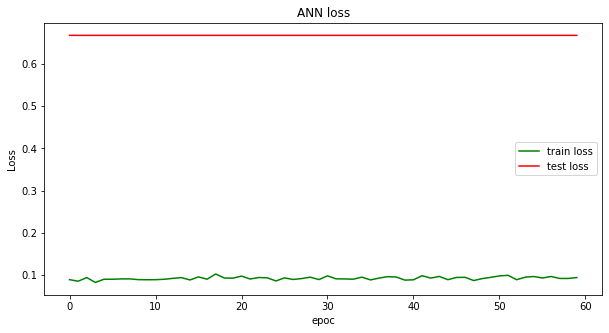

In [1594]:
# Plot training loss function 
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.title("ANN loss")

train_loss = history['train_loss']
test_loss = history['test_loss']

plt.plot(train_loss, 'g', label='train loss')
plt.plot(test_loss, 'r', label='test loss')

plt.xlabel("epoc")
plt.ylabel("Loss")
plt.legend()

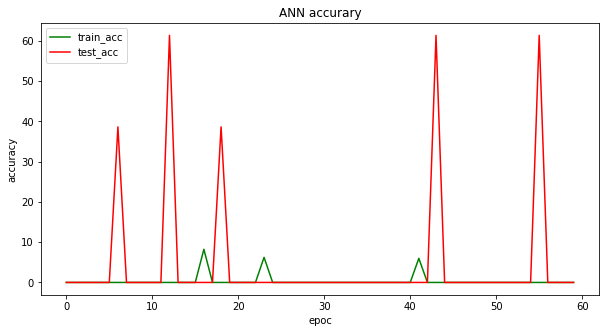

In [1595]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.title("ANN accurary")

train_loss = history['train_acc']
test_loss = history['test_acc']

plt.plot(train_loss, 'g', label='train_acc')
plt.plot(test_loss, 'r', label='test_acc')

plt.xlabel("epoc")
plt.ylabel("accuracy")
plt.legend()

### Validating model 

In [1765]:
# Load hold out data for a quick yesy
nsw_hold_out = np.array(nsw_hold_out)

features_validation = nsw_hold_out[:,1:]     
target_validation = nsw_hold_out[::,0]  

features_validation = torch.tensor(features_validation)
target_validation = torch.tensor(target_validation).unsqueeze(1)

dataset = CustomDataset(features = features_validation,targets = target_validation)

validation_loader = DataLoader(dataset=dataset, batch_size=batch_size,shuffle=True)


tensor([0.], dtype=torch.float64)

In [1780]:
dataset = CustomDataset(features = features_validation,targets = target_validation)

X = dataset.features
Y = dataset.targets

X = X.float()
Y = Y.float()

In [1772]:
ff_net = NeuralNetwork()

In [1789]:
#Get a single sample
input, target = X, Y


In [1820]:
class_mapping = ["0","1"]

def predict(model,input,target,class_mapping):
  model.eval()
  with torch.no_grad():
    predictions = model(input) # tensor (n_samples,n_classes) -> [[0.2,0.2,...,0.6]]
    predicted_index = predictions[1].argmax(0)
    prediced = class_mapping[predicted_index]
    expected = target[1]
  return prediced,expected


In [1821]:
prediced,expected = predict(ff_net,input,target,class_mapping)
print(f"predicted: '{prediced}','expected: '{expected}'")

predicted: '0','expected: 'tensor([1.])'


In [1834]:
predictions = model(input)
predictions[1]

tensor([0.5855], grad_fn=<SelectBackward0>)

<p> cps1 match </p>

<p> cps1 match </p>